In [79]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})

In [80]:
data=pd.read_csv("Processed-nhanes3.csv")

In [81]:
data.columns

Index(['uralb', 'trig', 'hdl', 'chol', 'hldhx', 'htnhx', 'sbp', 'dbp', 'bmi',
       'smokehx', 'ses', 'sex', 'age', 'hf', 'stroke', 'mi', 'hba1c',
       'mortstat', 'metabolic', 'race_hispanic', 'race_multiracial',
       'race_non hispanic black', 'race_non hispanic white'],
      dtype='object')

In [82]:
data.head()

,uralb,trig,hdl,chol,hldhx,htnhx,sbp,dbp,bmi,smokehx,...,hf,stroke,mi,hba1c,mortstat,metabolic,race_hispanic,race_multiracial,race_non hispanic black,race_non hispanic white
0,1.6,4.584967,4.189655,236.0,2.0,0,4.875197,4.290459,3.317816,0,...,0,0,0,5.3,alive,0,1,0,0,0
1,11.3,4.543295,3.931826,260.0,1.0,0,4.787492,4.248495,3.218876,0,...,0,0,0,9.1,alive,0,0,0,1,0
2,0.4,5.141664,3.737670,156.0,2.0,0,4.852030,4.290459,3.610918,0,...,0,0,0,5.0,alive,1,1,0,0,0
3,1.8,5.318120,3.850148,244.0,2.0,0,4.762174,4.304065,3.222868,1,...,0,0,0,5.9,alive,0,0,0,1,0
4,105.0,6.171701,3.401197,212.0,1.0,1,5.043425,4.510860,3.624341,0,...,0,0,0,5.7,dead,1,0,0,1,0


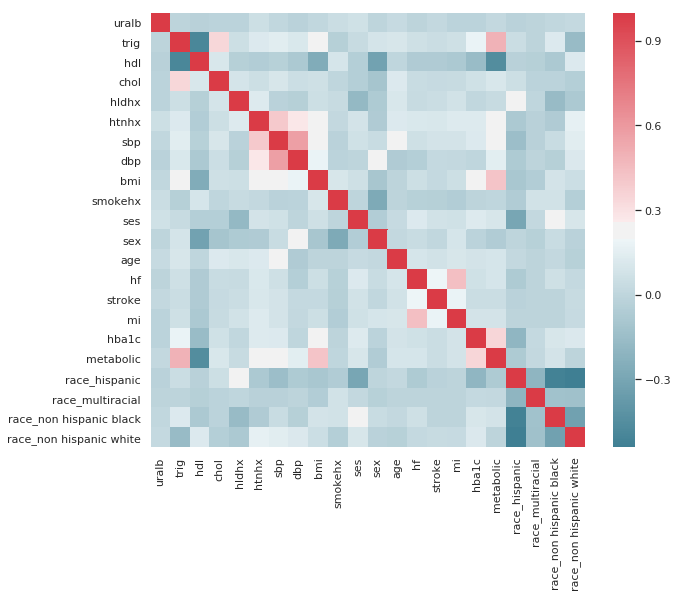

In [83]:
sns.heatmap(data.corr(), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True)

#### Feature selection

In [84]:
Y = data['mortstat']

In [85]:
del data['mortstat']

In [86]:
X = data

### Center data and scale

In [87]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

/home/jibin/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jibin/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [88]:
H = X

In [89]:
X.shape

(3378, 22)

In [90]:
Y = np.ravel(Y)

In [91]:
Y = np.array(Y == 'alive', dtype=int)

In [99]:
Y

array([1, 1, 1, ..., 1, 1, 1])

### DoubleML
1. Regress Y on X for feature selection, to obtain H (ignored), hence H = X
2. Regress T on X-T for feature selection, to obtain K (ignored), hence K = X-T
3. Regress Y on H and obtain residual, Y_res
4. Regress T on K and obtain residual, T_res
5. Regress Y_res on T_res, and obtain coefficients

In [100]:
X_T = data[[x for x in data.columns if x != 'metabolic']]

In [101]:
X_T.head()

,uralb,trig,hdl,chol,hldhx,htnhx,sbp,dbp,bmi,smokehx,...,sex,age,hf,stroke,mi,hba1c,race_hispanic,race_multiracial,race_non hispanic black,race_non hispanic white
0,1.6,4.584967,4.189655,236.0,2.0,0,4.875197,4.290459,3.317816,0,...,0,48.583333,0,0,0,5.3,1,0,0,0
1,11.3,4.543295,3.931826,260.0,1.0,0,4.787492,4.248495,3.218876,0,...,1,48.500000,0,0,0,9.1,0,0,1,0
2,0.4,5.141664,3.737670,156.0,2.0,0,4.852030,4.290459,3.610918,0,...,0,56.750000,0,0,0,5.0,1,0,0,0
3,1.8,5.318120,3.850148,244.0,2.0,0,4.762174,4.304065,3.222868,1,...,1,50.166667,0,0,0,5.9,0,0,1,0
4,105.0,6.171701,3.401197,212.0,1.0,1,5.043425,4.510860,3.624341,0,...,1,48.416667,0,0,0,5.7,0,0,1,0


In [102]:
K = X_T

### Regressing Y on H

In [103]:
clf = AdaBoostClassifier()

In [104]:
clf.fit(H,Y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [105]:
Y_prob = clf.predict_proba(H)

#### Y Residual

In [106]:
Y[:10]

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1])

In [107]:
Y_prob[:10,1]

array([0.51537675, 0.50760272, 0.51091661, 0.52157705, 0.49426725,
       0.50158466, 0.50864155, 0.51715432, 0.50948886, 0.50687874])

In [108]:
Y_res = np.abs(Y - Y_prob[:,1])

#### T Residual

In [109]:
clf.fit(K,data['metabolic'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [110]:
T_prob = clf.predict_proba(K)

In [111]:
T_prob[:10,1]

array([0.4466371 , 0.45527476, 0.50728989, 0.49947878, 0.52860152,
       0.48658851, 0.47860915, 0.49249247, 0.52851972, 0.50322978])

In [112]:
data['metabolic'].values - T_prob[:,1]

array([-0.4466371 , -0.45527476,  0.49271011, ..., -0.44783758,
       -0.46119868, -0.46411502])

In [113]:
T_res = np.abs(data['metabolic'].values - T_prob[:,1])

### Regressing Y_res on T_res

In [114]:
Y_res[:10]

array([0.48462325, 0.49239728, 0.48908339, 0.47842295, 0.49426725,
       0.50158466, 0.49135845, 0.48284568, 0.49051114, 0.49312126])

In [115]:
T_res[:10]

array([0.4466371 , 0.45527476, 0.49271011, 0.49947878, 0.47139848,
       0.48658851, 0.47860915, 0.50750753, 0.47148028, 0.50322978])

In [116]:
T_res = T_res.reshape(-1,1)

In [117]:
from sklearn.linear_model import LinearRegression

In [118]:
clf = LinearRegression(fit_intercept=False)

In [119]:
clf.fit(T_res,Y_res)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [120]:
clf.coef_

array([1.04787341])

In [121]:
clf.intercept_

0.0

In [125]:
from sklearn.feature_selection import f_regression

### p-values between X and Y

In [128]:
sorted(zip(data.columns,f_regression(X, Y)[1]),key=lambda x: x[1])

[('age', 5.018829940473051e-38),
 ('sbp', 4.940167377267484e-31),
 ('hf', 1.9661818056174579e-23),
 ('smokehx', 3.675086191167638e-21),
 ('mi', 1.583970284450893e-18),
 ('htnhx', 3.1422215588821165e-17),
 ('hba1c', 1.3006689483453525e-15),
 ('ses', 3.0963937899113244e-13),
 ('stroke', 7.247482866978004e-13),
 ('sex', 1.7850058317133892e-10),
 ('metabolic', 1.4624662744731789e-08),
 ('race_non hispanic white', 4.924682445521901e-08),
 ('uralb', 6.812572936932407e-05),
 ('hdl', 0.000224014671625042),
 ('race_hispanic', 0.0003403401639970923),
 ('hldhx', 0.001410901268165167),
 ('trig', 0.002229216589948807),
 ('race_multiracial', 0.003228124427505733),
 ('dbp', 0.010968830742607537),
 ('chol', 0.27159588886217184),
 ('bmi', 0.8750052556093116),
 ('race_non hispanic black', 0.9482974345185232)]

### p-values between T_res and Y_res

In [129]:
f_regression(T_res,Y_res)[1]

array([0.1297271])